## DASC 550 Project1: Churn Classification Problem
### Burak Albayrak
### 0078324

#### Submission Deadline: August 15, 2022 11:59 PM

In this project, you are going to build an end-to-end machine learning solution using a multilayer preceptron for churn classification problem. You should use `tensorflow` library to build your neural network.

The data set is provided in `Project1.csv` file, which contains 10000 rows and 14 columns. Some of the columns such as RowNumber and CustomerID might be useless for classification. The binary target variable is given in `Exited` column.

While building your classification model, you should use the first 8000 rows as training set and the remaining 2000 rows as test set. You should report the predictive performances on learning, validation and test sets.

You should also decide (i) which features will be included in the classifier, (ii) which features will be preprocessed (e.g., categorical to numeric conversion, scaling, etc.). You should report your decisions and the reasoning behind them.

You should also report the metrics you choose to measure the performance of the solution you developed and the reasoning behind your choices. Please note that the training and test sets have 20.59\% and 19.50\% positive samples, respectively.

In [1]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np

##### Selecting Features
* Since our data consist of some categorical columns which has no relation with the actual data, I dropped RowNumber, CustomerId and Surname Columns
* I used label encoding for categorical columns which has meaning for our model. These columns are Geography and Gender.
* Since our data has numeric columns with different ranges, scaled all columns with the min max scaling. While doing this I was careful to do fitting and transforming on training data and this transformation applied to test data

##### Metrics and Evaluating Model

* First I constructed MLP model with only consist of layers and output node.
* Since our problem is binary classification, I put sigmoid activation to output node
* Since our data is unbalanced, I gave class weights to the fit function as a parameter
* For metrics I only used accuracy for this model
*                 Training accuracy: 0.8723 - auc: 0.9225
*                 Test accuracy: 0.8450 - auc: 0.8221
* In other model additionally, I used early stopping, drop out layer
* Result for best epoch is:
*                   Validation Accuracy: 0.8390 
                    Validation AUC: 0.8598


In [2]:
def csv_to_array(csv_path, target_column):
    dataset = pd.read_csv(csv_path)
    X = dataset.drop(axis=1,columns=[target_column, "RowNumber", "CustomerId", "Surname"]).to_numpy()
    y = dataset[target_column].to_numpy()
    return X,y
X,y = csv_to_array('Project1.csv', "Exited")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [4]:
# Checking for is the encoding is correnct

# print(X_test[5:20])


#### LABEL ENCODING

In [5]:
# Label encoding for categorical columns

def preprocess(data, col_num):
    le = preprocessing.LabelEncoder()
    le.fit(data[:,col_num])
    data[:,col_num] = le.transform(data[:,col_num])
    print(f"Classes for column number:{col_num} "+str(list(le.classes_)))
    return data
    
# Applying preprocess for specific columns

for i in range(1,3):
    X_train = preprocess(X_train, i)
    X_test = preprocess(X_test, i)


Classes for column number:1 ['France', 'Germany', 'Spain']
Classes for column number:1 ['France', 'Germany', 'Spain']
Classes for column number:2 ['Female', 'Male']
Classes for column number:2 ['Female', 'Male']


In [6]:
# Checking for is the encoding is correnct

# print(X_test[5:20])

In [7]:
# Checking shape of data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8000, 10) (8000,)
(2000, 10) (2000,)


In [8]:
def scaling_columns(train_data,test_data):
    scaler = preprocessing.MinMaxScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    return train_data, test_data

In [9]:
X_train, X_test = scaling_columns(X_train, X_test)

In [10]:
Xlearn, Xvalidation, ylearn, yvalidation = train_test_split(X_train, y_train, test_size = 0.25,
                                                            random_state = 1234, shuffle = True)
print(Xlearn.shape, ylearn.shape, Xvalidation.shape, yvalidation.shape)

(6000, 10) (6000,) (2000, 10) (2000,)


#### VANILLA MLP MODEL

In [11]:
mlp_churn = keras.Sequential([
    keras.layers.Input(name = "input", shape = (Xlearn.shape[1],)),
    keras.layers.Flatten(name = "vectorize"),
    keras.layers.Dense(128, name = "first_relu", activation = "relu"),
    keras.layers.Dense(32, name = "second_relu", activation = "relu"),
    keras.layers.Dense(np.max(y_train), name = "output", activation = "sigmoid")
])

mlp_churn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vectorize (Flatten)         (None, 10)                0         
                                                                 
 first_relu (Dense)          (None, 128)               1408      
                                                                 
 second_relu (Dense)         (None, 32)                4128      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________


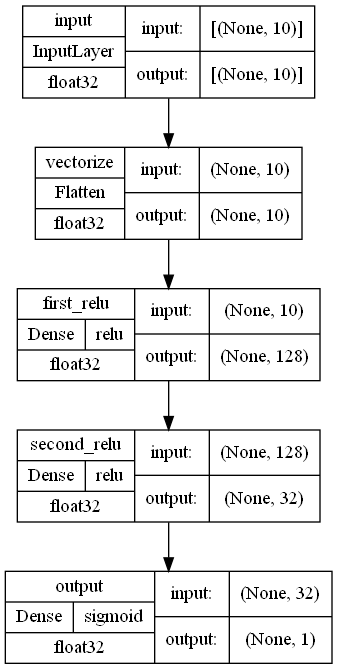

In [12]:
keras.utils.plot_model(mlp_churn,
                       show_shapes = True,
                       show_dtype = True,
                       show_layer_activations = True
                       )

In [13]:
mlp_churn.compile(loss='binary_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate = 0.001),
                  metrics = ["accuracy"])

In [14]:
mlp_history = mlp_churn.fit(X_train, y_train,
             epochs = 100,
             batch_size = 16,
             class_weight = {1: 0.20,
                            0: 0.80},
             validation_data = (Xvalidation, yvalidation),
             verbose = 0)

In [15]:
print(mlp_churn.evaluate(X_train, y_train))
print(mlp_churn.evaluate(Xvalidation, yvalidation))
print(mlp_churn.evaluate(X_test, y_test))

250/250 [==============================] - 0s 1ms/step - loss: 0.3246 - accuracy: 0.8784
[0.32459041476249695, 0.8783749938011169]
63/63 [==============================] - 0s 989us/step - loss: 0.3196 - accuracy: 0.8790
[0.31956470012664795, 0.8790000081062317]
63/63 [==============================] - 0s 991us/step - loss: 0.4659 - accuracy: 0.8470
[0.46593961119651794, 0.847000002861023]


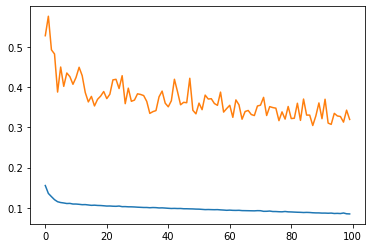

In [16]:
plt.plot(mlp_history.history["loss"])
plt.plot(mlp_history.history["val_loss"])
plt.show()

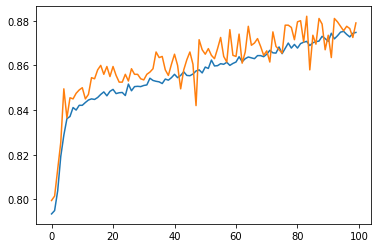

In [17]:
plt.plot(mlp_history.history["accuracy"])
plt.plot(mlp_history.history["val_accuracy"])
plt.show()

#### WITH EARLY STOPPING AND DROPOUT LAYER

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vectorize (Flatten)         (None, 10)                0         
                                                                 
 first_relu (Dense)          (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 second_relu (Dense)         (None, 32)                4128      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________


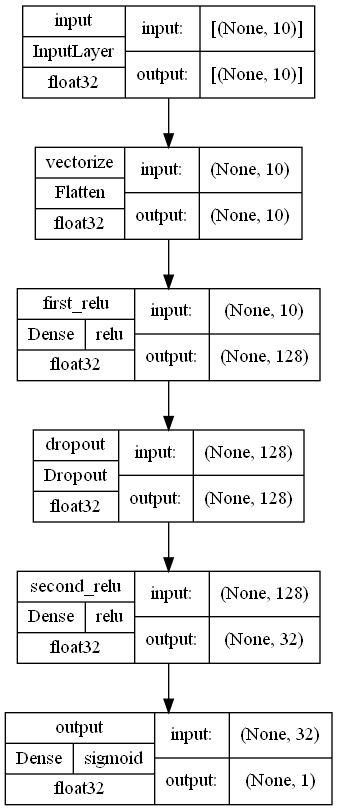

In [18]:
early_stopping1 = keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                               patience = 10, restore_best_weights = True)
early_stopping2 = keras.callbacks.EarlyStopping(monitor = "val_auc", 
                                               patience = 10, restore_best_weights = True)

mlp_churn_ea_do = keras.Sequential([
    keras.layers.Input(name = "input", shape = (Xlearn.shape[1],)),
    keras.layers.Flatten(name = "vectorize"),
    keras.layers.Dense(128, name = "first_relu", activation = "relu"),
    keras.layers.Dropout(name = "dropout", rate = 0.5),
    keras.layers.Dense(32, name = "second_relu", activation = "relu"),
    keras.layers.Dense(np.max(y_train), name = "output", activation = "sigmoid")
])

mlp_churn_ea_do.summary()
keras.utils.plot_model(mlp_churn_ea_do,
                       show_shapes = True,
                       show_dtype = True,
                       show_layer_activations = True
                       )

In [19]:
mlp_churn_ea_do.compile(loss='binary_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate = 0.001),
                  metrics = ["accuracy", "AUC"])

In [20]:
mlp_churn_ea_do_history = mlp_churn_ea_do.fit(Xlearn, ylearn,
                                    epochs = 100,
                                    class_weight = {1: 0.20,
                                                    0: 0.80},
                                    verbose = 1, batch_size = 32,
                                    callbacks = [early_stopping1, early_stopping2],
                                    validation_data = (Xvalidation, yvalidation))

Epoch 1/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1948 - accuracy: 0.7730 - auc: 0.5466 - val_loss: 0.6174 - val_accuracy: 0.7995 - val_auc: 0.6148
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1523 - accuracy: 0.7923 - auc: 0.6429 - val_loss: 0.5773 - val_accuracy: 0.7995 - val_auc: 0.6764
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1464 - accuracy: 0.7923 - auc: 0.6940 - val_loss: 0.5646 - val_accuracy: 0.7995 - val_auc: 0.7210
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1426 - accuracy: 0.7923 - auc: 0.7206 - val_loss: 0.4939 - val_accuracy: 0.8005 - val_auc: 0.7540
Epoch 5/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1409 - accuracy: 0.7922 - auc: 0.7327 - val_loss: 0.5225 - val_accuracy: 0.8000 - val_auc: 0.7686
Epoch 6/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1391 - accuracy: 0.7923 - auc: 0.7417 - val_loss

In [21]:
print(early_stopping1.best_epoch)
print(early_stopping2.best_epoch)

12
21


In [22]:
print(mlp_churn_ea_do.evaluate(X_train, y_train))
print(mlp_churn_ea_do.evaluate(Xvalidation, yvalidation))
print(mlp_churn_ea_do.evaluate(X_test, y_test))

250/250 [==============================] - 0s 1ms/step - loss: 0.4226 - accuracy: 0.8267 - auc: 0.8428
[0.42257773876190186, 0.8267499804496765, 0.8428197503089905]
63/63 [==============================] - 0s 1ms/step - loss: 0.4063 - accuracy: 0.8340 - auc: 0.8527
[0.4062604010105133, 0.8339999914169312, 0.8527103066444397]
63/63 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.8305 - auc: 0.8121
[0.43470749258995056, 0.8305000066757202, 0.8121285438537598]


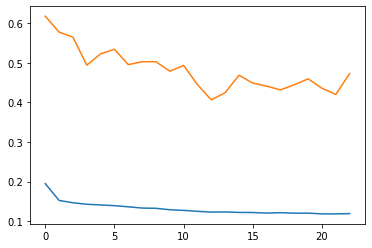

In [23]:
plt.plot(mlp_churn_ea_do_history.history["loss"])
plt.plot(mlp_churn_ea_do_history.history["val_loss"])
plt.show()

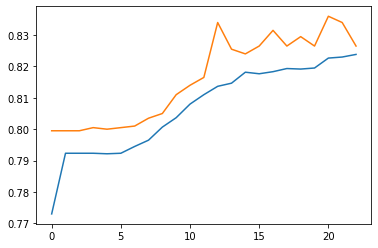

In [24]:
plt.plot(mlp_churn_ea_do_history.history["accuracy"])
plt.plot(mlp_churn_ea_do_history.history["val_accuracy"])
plt.show()